# JumpCloud OS Patching Dashboard - V1

**Note**
* Only Windows, MacOS, and Ubuntu Desktop (with UI) are in scope atm.

**Reference**

* [Get Started: Patch Management](https://jumpcloud.com/support/get-started-patch-management)


**Requirement**
* Jupyter Notebook with Python's Conda distribution - recommended all-in-one package [Anaconda](https://www.anaconda.com/download).

## Step 1 - Getting the Data from your JC Org

**Please consider to use your JC Read-Only API key, here are the steps**:
 1. Create a [read-only admin role](https://jumpcloud.com/support/admin-portal-roles).
 2. [Obtaining Your API Key](https://jumpcloud.com/support/jumpcloud-apis).


In [1]:
apikey = 'read-only-api-key'


In [2]:
# requires conda core
import requests
import pandas as pd
from packaging import version

# Release Info URLs and API Key
win11ReInfoUrl = "https://learn.microsoft.com/en-us/windows/release-health/windows11-release-information"
win10ReInfoUrl = "https://learn.microsoft.com/en-us/windows/release-health/release-information"
macOSReInfoUrl = 'https://en.wikipedia.org/wiki/MacOS_version_history'
UbuntuReInfoUrl = "https://wiki.ubuntu.com/Releases"

# A Function to query all in scope systems in your org, only the in scope OSes.
def getJCSystem (apikey,limit=100,skip=0):
    base_url = "https://console.jumpcloud.com/api"
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json',
        'x-api-key': apikey
    }
    url = f"{base_url}/systems"
    systems = []
    while True:
        params = {
            'limit': limit, 
            'skip': skip,
            'filter[or][0]': 'os:$eq:Mac OS X',
            'filter[or][1]': 'os:$eq:Ubuntu',
            'filter[or][2]': 'os:$eq:Windows'      
        
        }
        response = requests.get(url, headers=headers,params=params)
        skip += limit 
        results = response.json()['results']
        if response.status_code == 200 and results:
            systems += results
        else:
            break
    return systems

JCSystems = getJCSystem(apikey=apikey)

# Win11 Tables
Win11_All = pd.read_html(win11ReInfoUrl)
Win11_CuVer = Win11_All[0]

''' Use for laters

Win11_22H2 = Win11_All[1]
Win11_21H2 = Win11_All[2]
'''

# MacOS Table
MacOS_All = pd.read_html(macOSReInfoUrl)[2]

MacOS_All.drop(MacOS_All.index[-1], inplace=True)
MacOS_All.drop(['Kernel', 'Dateannounced', 'Releasedate','Darwinversion','Processorsupport','Applicationsupport','Unnamed: 9'], axis=1, inplace=True)
MacOS_All['Version Number'] = MacOS_All['Most recentversion'].str.rsplit('(', 1).str[0]
MacOS_All['Release Date'] = MacOS_All['Most recentversion'].str.rsplit('(', 1).str[1]

# Remove the trailing ')' from the 'Release Date' column
MacOS_All['Release Date'] = MacOS_All['Release Date'].str.rstrip(')')
# Convert the 'Release Date' column to datetime format
MacOS_All['Release Date'] = pd.to_datetime(MacOS_All['Release Date'], errors='coerce')
# If you want to drop the original 'Most recentversion' column
MacOS_All = MacOS_All.drop('Most recentversion', axis=1)

# Ubuntu Table
Ubuntu_All = pd.read_html(UbuntuReInfoUrl)[1]
Ubuntu_All.columns = Ubuntu_All.iloc[0]
Ubuntu_All = Ubuntu_All.iloc[1:]
Ubuntu_All.drop('Docs', axis=1, inplace=True)

sysPatchInfoDF =pd.DataFrame(
    {
        'Hostname':[],
        'DisplayName':[],
        'OS':[],
        'OS Family':[],
        'OS Patch Level':[],
        'UpToDate':[],
        'Lastest Release':[],
        'systemID':[]
    }
)

# Matching the data with Version
for system in JCSystems:
    # Build a new DF for the systems and patching level
    UpToDate = False
    os = system['os'] +' '+system['version']
    systemVerDetails = system['osVersionDetail']
    # Compare the patch level with the latest for each OS
    # MacOS
    if system['osFamily'] == 'darwin':
        osPatchLv = systemVerDetails['revision']
        lastestRe = MacOS_All.loc[systemVerDetails['osName'] + ' '+systemVerDetails['major'] == MacOS_All['Version']].values[0][2]
        lastestRe = lastestRe.split('(')[1].rstrip(')') # Taking out the revision number for comparision
        UpToDate = osPatchLv == lastestRe

    # Linux - For Ubuntu ONLY
    elif system['os'] == 'Ubuntu':
        if systemVerDetails['patch'] == '':
            patchNumber = '0'
        osPatchLv = str(systemVerDetails['major']) + '.' + str(systemVerDetails['minor']) + '.' + patchNumber
        osPatchLv = version.parse(osPatchLv) # Coverting to Version object for comparision
        lastestRe = Ubuntu_All.loc[systemVerDetails['releaseName'] == Ubuntu_All['Code name']].values[0][0]
        lastestRe = version.parse(str(lastestRe.split()[1]))  # Coverting to Version object for comparision
        UpToDate = osPatchLv == lastestRe
    # Windows
    elif system['osFamily'] == 'windows':
        osPatchLv = systemVerDetails['patch'] + '.' + systemVerDetails['revision']
        osPatchLv = version.parse(osPatchLv)
        lastestRe = str((Win11_CuVer.loc[Win11_CuVer['Version'] == systemVerDetails['releaseName']])['Latest build'].values[0])
        lastestRe = version.parse(lastestRe)
        UpToDate = lastestRe == osPatchLv

    new_data = [
        system['hostname'], 
        system['displayName'], 
        os,
        system['os'],
        osPatchLv,
        UpToDate,
        lastestRe,
        system['id']
    ]
    new_series = pd.Series(new_data, index=sysPatchInfoDF.columns)
    sysPatchInfoDF = pd.concat([sysPatchInfoDF, new_series.to_frame().T], ignore_index=True)

# Next, do the plotting

In [3]:
# Take a glance of your data
sysPatchInfoDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Hostname         14 non-null     object
 1   DisplayName      14 non-null     object
 2   OS               14 non-null     object
 3   OS Family        14 non-null     object
 4   OS Patch Level   14 non-null     object
 5   UpToDate         14 non-null     object
 6   Lastest Release  14 non-null     object
 7   systemID         14 non-null     object
dtypes: object(8)
memory usage: 1.0+ KB


## Step 2 - Export the Data to a CSV

In [5]:
from datetime import datetime
today = datetime.today().strftime("%Y-%m-%d")
outdatedSystems = sysPatchInfoDF[sysPatchInfoDF['UpToDate'] == False]

# Export both data sets to csv
csvPath = '/Users/ssong/repo/jc/PatchDashboard'
sysPatchInfoDF.to_csv(f'{csvPath}/syspatch-{today}.csv') # all systems' data
outdatedSystems.to_csv(f'{csvPath}/outdatedSystems-{today}.csv', index=False) # Only the outdated systems' data

## Step 3 - Plot the Dashboard

### Overall Patching Status

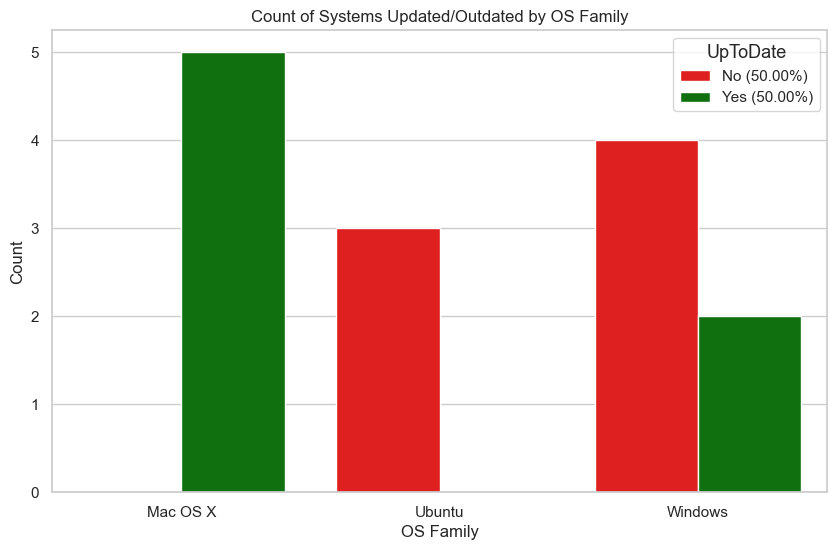

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
sns.set(style="whitegrid")

# Calculate overall percentage of systems that are updated vs outdated
total_systems = sysPatchInfoDF.shape[0]
updated_systems = sysPatchInfoDF[sysPatchInfoDF['UpToDate'] == True].shape[0]
outdated_systems = sysPatchInfoDF[sysPatchInfoDF['UpToDate'] == False].shape[0]

# Calculate percentages
updated_percentage = (updated_systems / total_systems) * 100
outdated_percentage = (outdated_systems / total_systems) * 100

# Count Plot for OS Family and UpToDate with overall percentages
plt.figure(figsize=(10, 6))
sns.countplot(x="OS Family", hue="UpToDate", data=sysPatchInfoDF,palette=['red', 'green'])
plt.title('Count of Systems Updated/Outdated by OS Family')
plt.ylabel('Count')
plt.xlabel('OS Family')

# Modify legend to include the percentage information
plt.legend(title='UpToDate', title_fontsize='13', labels=[f'No ({outdated_percentage:.2f}%)', f'Yes ({updated_percentage:.2f}%)'])

plt.show()


### View by each OS family

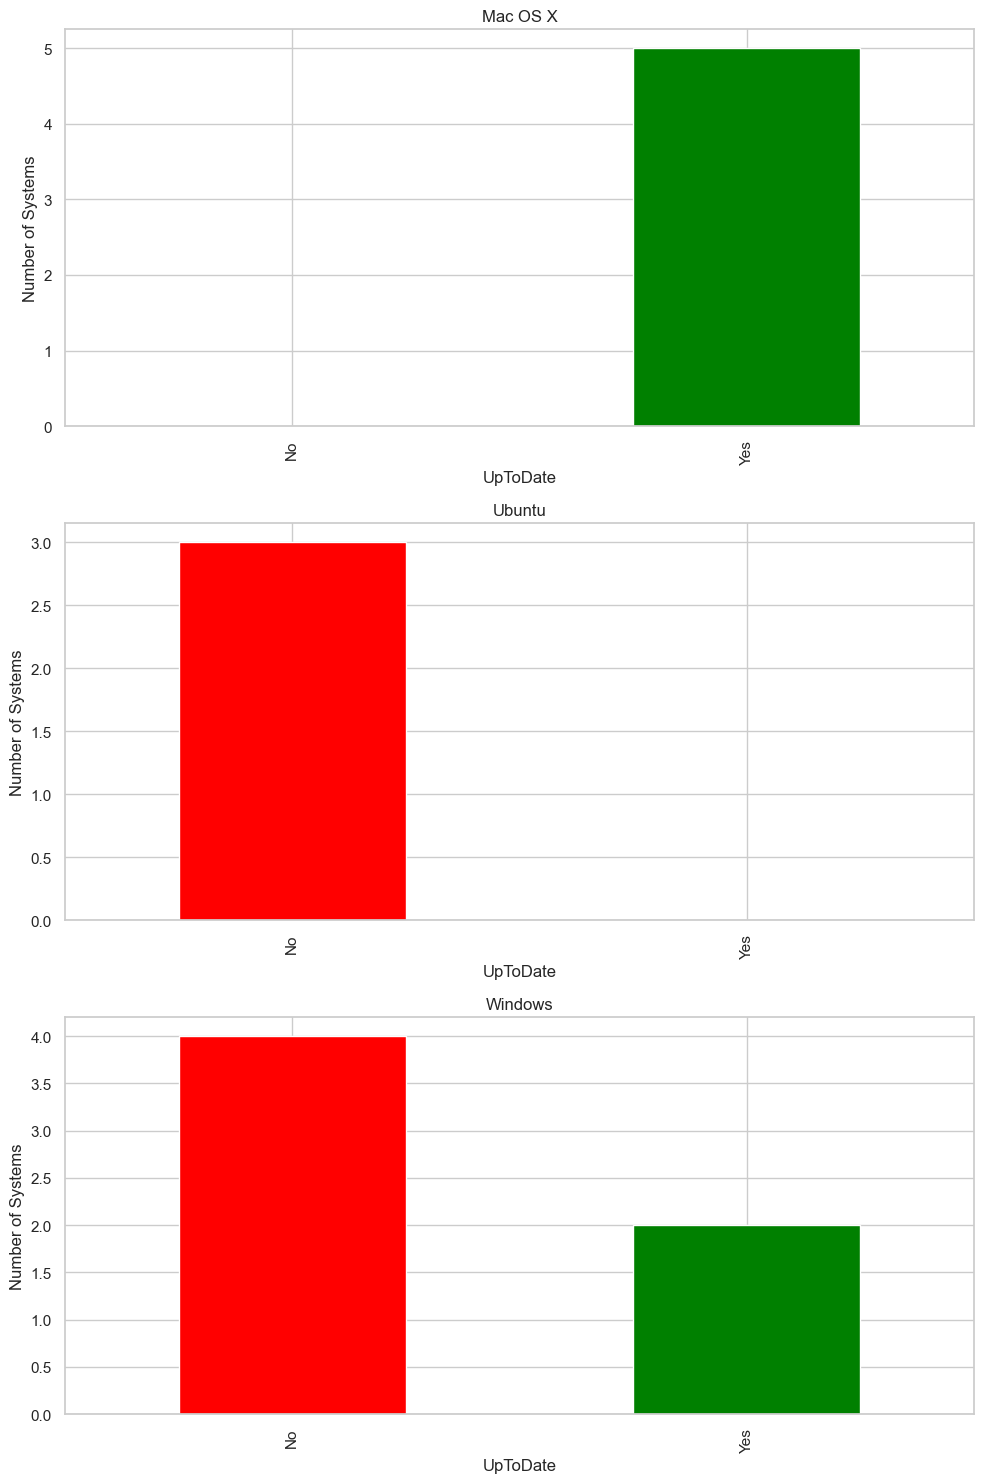

In [7]:

# Replace True and False with 'Yes' and 'No'
sysPatchInfoDF['UpToDate'] = sysPatchInfoDF['UpToDate'].map({True: 'Yes', False: 'No'})

# Group the data by 'OS Family' and 'UpToDate?' and get the size of each group
grouped = sysPatchInfoDF.groupby(['OS Family', 'UpToDate']).size().unstack()

# Define the color map
color_map = {'Yes': 'green', 'No': 'red'}

# Plot the data
fig, axs = plt.subplots(3, 1, figsize=(10,15))

os_families = sysPatchInfoDF['OS Family'].unique()

for i, os_family in enumerate(os_families):
    grouped.loc[os_family].plot(kind='bar', ax=axs[i], color=[color_map.get(x, 'blue') for x in grouped.columns])
    axs[i].set_title(os_family)
    axs[i].set_xlabel('UpToDate')
    axs[i].set_ylabel('Number of Systems')

plt.tight_layout()
plt.show()
